In [1]:
import sys
sys.path.append("..")
from lunar_spectra_workbench.load import load_spectrum, load_metadata, build_catalog




In [2]:
catalog = build_catalog("../data/raw")
catalog[:20]

[{'file': WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/ch3_lib_045_20230902T074049_00_l0.csv'),
  'type': 'L0',
  'name': 'ch3_lib_045_20230902T074049_00_l0'},
 {'file': WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/ch3_lib_045_20230902T074049_00_l0_0_1.csv'),
  'type': 'L0',
  'name': 'ch3_lib_045_20230902T074049_00_l0_0_1'},
 {'file': WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/ch3_lib_045_20230902T074049_00_l0_1_2.csv'),
  'type': 'L0',
  'name': 'ch3_lib_045_20230902T074049_00_l0_1_2'},
 {'file': WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_01_l0/ch3_lib_045_20230902T074049_01_l0.csv'),
  'type': 'L0',
  'name': 'ch3_lib_045_20230902T074049_01_l0'},
 {'file': WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_01_l0/ch3_lib_045_20230902T074049_01_l0_0_1.csv'),
  'type': 'L0',
  'name': 'ch3_lib_045_20230902T074049_01_l0_0_1'},
 {'file': WindowsPath('../data/raw/20230902/ch3_lib_045_20230

In [3]:
from lunar_spectra_workbench.clean import clean_spectrum
from lunar_spectra_workbench.load import load_spectrum

df = load_spectrum(
    "../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/"
    "ch3_lib_045_20230902T074049_00_l0.csv"
)

cleaned = clean_spectrum(df)
cleaned.head()


,Pixel,Raw,Baseline,Corrected,Smoothed,Normalized
0,0,308.0,308.0,0.0,26.125874,0.047629
1,1,378.0,308.0,70.0,51.636364,0.079311
2,2,424.0,308.0,116.0,70.638695,0.102912
3,3,370.0,308.0,62.0,83.573427,0.118976
4,4,406.0,308.0,98.0,90.881119,0.128052


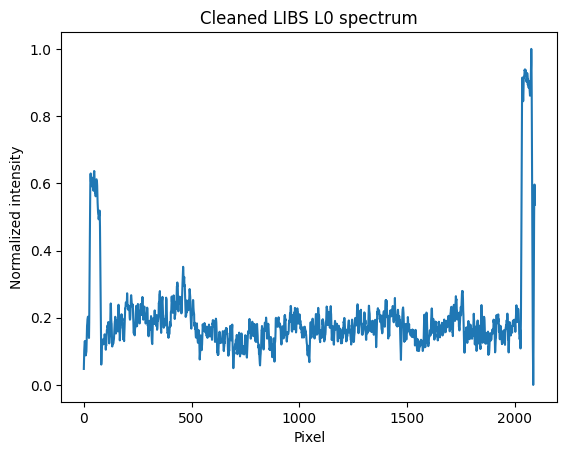

In [4]:
import matplotlib.pyplot as plt

plt.plot(cleaned["Pixel"], cleaned["Normalized"])
plt.xlabel("Pixel")
plt.ylabel("Normalized intensity")
plt.title("Cleaned LIBS L0 spectrum")
plt.show()


In [5]:
from lunar_spectra_workbench.peaks import detect_peaks

peaks = detect_peaks(cleaned)
peaks.head()


,Pixel,Height,Prominence,Width
0,59,0.612044,0.050674,6.054285
1,114,0.187179,0.063551,10.287485
2,125,0.242445,0.128107,6.544291
3,161,0.238629,0.108264,5.445855
4,175,0.210354,0.077812,10.537875


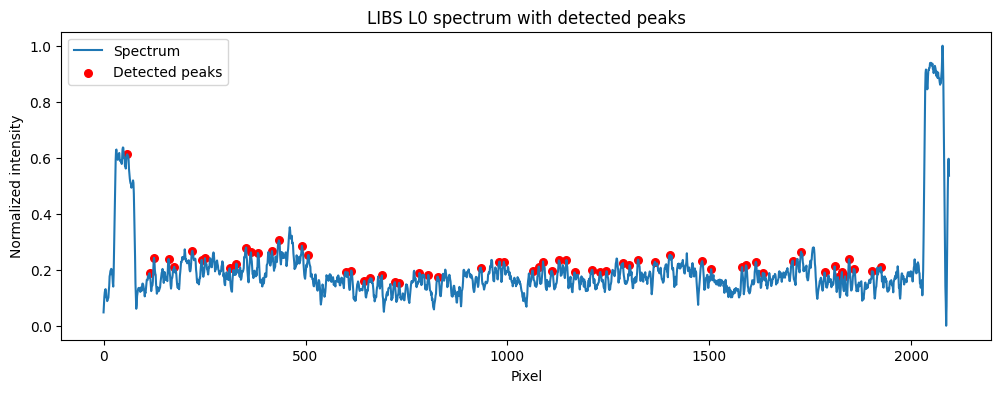

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(cleaned["Pixel"], cleaned["Normalized"], label="Spectrum")

plt.scatter(
    peaks["Pixel"],
    peaks["Height"],
    color="red",
    s=30,
    label="Detected peaks"
)

plt.xlabel("Pixel")
plt.ylabel("Normalized intensity")
plt.title("LIBS L0 spectrum with detected peaks")
plt.legend()
plt.show()


In [7]:
from lunar_spectra_workbench.metrics import peak_metrics

metrics = peak_metrics(
    peaks,
    pixel_range=(50, 1950)
)

metrics


total_peaks              62.000000
peaks_per_1000_pixels    32.631579
mean_prominence           0.081026
median_prominence         0.074514
mean_width                7.192474
median_width              6.632471
dtype: float64

In [8]:
from lunar_spectra_workbench.match import match_elements

matches = match_elements(peaks, tolerance_nm=0.8)
matches.head()



,Pixel,Wavelength_nm,Element,Ref_wavelength_nm,Delta_nm,Confidence,Peak_height,Prominence
0,353.0,288.25,Si,288.2,0.05,0.9375,0.279255,0.139099
1,434.0,308.50,Al,308.2,0.30,0.6250,0.304875,0.091939
2,689.0,372.25,Fe,371.9,0.35,0.5625,0.179557,0.092652


In [9]:
matches.groupby("Element").agg(
    count=("Element", "count"),
    mean_confidence=("Confidence", "mean")
).sort_values("count", ascending=False)


,count,mean_confidence
Element,,
Al,1,0.6250
Fe,1,0.5625
Si,1,0.9375


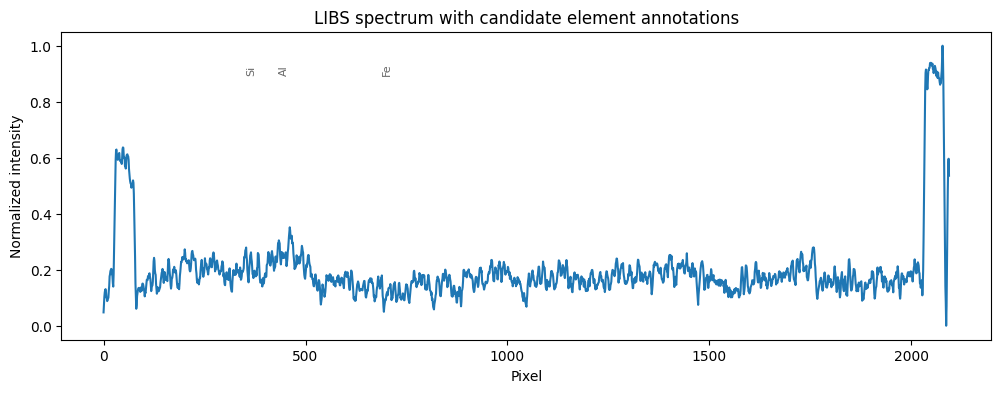

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(cleaned["Pixel"], cleaned["Normalized"], label="Spectrum")

for _, row in matches.iterrows():
    plt.text(
        row["Pixel"],
        0.9,
        row["Element"],
        rotation=90,
        fontsize=8,
        alpha=0.6
    )

plt.title("LIBS spectrum with candidate element annotations")
plt.xlabel("Pixel")
plt.ylabel("Normalized intensity")
plt.show()


In [11]:
from lunar_spectra_workbench.calibration_fit import (
    select_calibration_points,
    fit_linear_calibration
)

calib_pts = select_calibration_points(matches)
model, stats = fit_linear_calibration(calib_pts)

stats


{'a': np.float64(0.24927472598952732),
 'b': np.float64(200.1235014798192),
 'rmse_nm': np.float64(0.08024845958977635),
 'max_error_nm': np.float64(0.10873255927407399),
 'num_points': 3}

In [12]:
calib_pts

,Pixel,Ref_wavelength_nm
0,353.0,288.2
1,434.0,308.2
2,689.0,371.9


In [18]:
from pathlib import Path

# Root directory for one day
day_dir = Path("../data/raw/20230902")

# Collect ONLY the main L0 CSV files (not sub-frames)
shot_csv_files = sorted(
    day_dir.glob("**/*_l0_*.csv")
)

len(shot_csv_files), shot_csv_files[:5]


(20,
 [WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/ch3_lib_045_20230902T074049_00_l0_0_1.csv'),
  WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/ch3_lib_045_20230902T074049_00_l0_1_2.csv'),
  WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_01_l0/ch3_lib_045_20230902T074049_01_l0_0_1.csv'),
  WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_01_l0/ch3_lib_045_20230902T074049_01_l0_1_2.csv'),
  WindowsPath('../data/raw/20230902/ch3_lib_045_20230902T074049_02_l0/ch3_lib_045_20230902T074049_02_l0_0_1.csv')])

In [26]:
df = load_spectrum("../data/raw/20230902/ch3_lib_045_20230902T074049_00_l0/ch3_lib_045_20230902T074049_00_l0.csv")

for idx, row in df.iterrows():
    row_df = row.to_frame().T   # convert Series → 1-row DataFrame
    cleaned = clean_spectrum(row_df)
    peaks = detect_peaks(cleaned)
    matches = match_elements(peaks)

matches



,Pixel,Wavelength_nm,Element,Ref_wavelength_nm,Delta_nm,Confidence,Peak_height,Prominence
0,410.0,302.50,Fe,302.1,0.40,0.2,0.335461,0.207271
1,576.0,344.00,Fe,344.1,0.10,0.8,0.188801,0.081076
2,689.0,372.25,Fe,371.9,0.35,0.3,0.186494,0.082761
3,772.0,393.00,Ca,393.4,0.40,0.2,0.187753,0.107218
4,1554.0,588.50,Na,588.9,0.40,0.2,0.176331,0.102425


In [15]:
from lunar_spectra_workbench.calibration_fit import (
    select_calibration_points,
    fit_linear_calibration
)

calib_pts = select_calibration_points(
    all_matches_df,
    min_confidence=0.3,
    min_prominence=0.08
)

len(calib_pts)


10

In [16]:
model, stats = fit_linear_calibration(calib_pts)
stats


{'a': np.float64(0.2500300305754065),
 'b': np.float64(199.92784962919055),
 'rmse_nm': np.float64(0.14619231062943505),
 'max_error_nm': np.float64(0.2591771622338115),
 'num_points': 10}

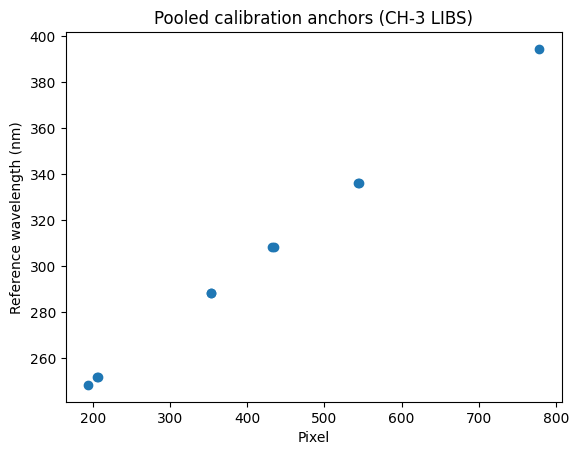

In [17]:
import matplotlib.pyplot as plt

plt.scatter(
    calib_pts["Pixel"],
    calib_pts["Ref_wavelength_nm"]
)
plt.xlabel("Pixel")
plt.ylabel("Reference wavelength (nm)")
plt.title("Pooled calibration anchors (CH-3 LIBS)")
plt.show()
